In [1]:
from google.colab import drive
drive.mount('/content/drive')

filename1 = 'drive/MyDrive/TextAnalytics/20191226-items.csv'
filename2 = 'drive/MyDrive/TextAnalytics/20191226-reviews.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.util import bigrams, trigrams
from nltk import ngrams
from collections import defaultdict
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
!pip install nltk==3.4

In [4]:
# Importo nuovo dataset
df = pd.read_csv('drive/MyDrive/TextAnalytics/post_data_understanding.csv')


#df_items = pd.read_csv(filename1)
#df_reviews = pd.read_csv(filename2)

# Preparazione generale

In [5]:
# Rinomino le colonne con nomi simili
df = df.rename(columns={'rating_x':'review_rating', 'title_x':'review_title', 
                        'title_y':'product_title', 'rating_y':'product_rating'})

# Drop colonna indice (sbagliato)
del df['Unnamed: 0']


df.head(2)

,asin,name,review_rating,date,year,verified,review_title,body,helpfulVotes,brand,product_title,url,image,product_rating,reviewUrl,totalReviews,price,originalPrice,language,english
0,B0009N5L7K,Marcel Thomas,1,"March 5, 2016",2016,True,Stupid phone,DON'T BUY OUT OF SERVICE,NaN,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0,de,0
1,B0009N5L7K,Stephen Cahill,1,"December 20, 2016",2016,True,Phones locked,1 star because the phones locked so I have to ...,NaN,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0,en,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61225 entries, 0 to 61224
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   asin            61225 non-null  object 
 1   name            61223 non-null  object 
 2   review_rating   61225 non-null  int64  
 3   date            61225 non-null  object 
 4   year            61225 non-null  int64  
 5   verified        61225 non-null  bool   
 6   review_title    61211 non-null  object 
 7   body            61207 non-null  object 
 8   helpfulVotes    23162 non-null  float64
 9   brand           61078 non-null  object 
 10  product_title   61225 non-null  object 
 11  url             61225 non-null  object 
 12  image           61225 non-null  object 
 13  product_rating  61225 non-null  float64
 14  reviewUrl       61225 non-null  object 
 15  totalReviews    61225 non-null  int64  
 16  price           61225 non-null  float64
 17  originalPrice   61225 non-null 

### Eliminazione missing values e parti superflue

In [7]:
# propongo di eliminare: ['asin', 'name', 'verified']
col = ['asin', 'name', 'verified', 'name', 'brand', 'url', 'image', 'reviewUrl', 'totalReviews', 'price', 'originalPrice']

df.drop(columns=col, inplace=True)

In [8]:
# Null values pre-drop

df.isna().sum()

review_rating         0
date                  0
year                  0
review_title         14
body                 18
helpfulVotes      38063
product_title         0
product_rating        0
language              0
english               0
dtype: int64

In [9]:
# Null values post-drop

print(len(df))
df.drop(columns=['helpfulVotes'], inplace=True)
df.dropna(inplace = True)
print(len(df))
df.isna().sum()

61225
61198


review_rating     0
date              0
year              0
review_title      0
body              0
product_title     0
product_rating    0
language          0
english           0
dtype: int64

In [10]:
null_reviews = []
for id, el in enumerate(df['body']):
  if el == "nan":
    print(id, el)

null_reviews

[]

### Eliminazione recensioni **non** in inglese

In [11]:
print(len(df))

# selecting rows based on condition
df = df[df['english'] == 1]

print(len(df))

61198
53337


### Trasformazione di 'review_rating' in variabile binaria

In [12]:
df['pos_review'] = [1 if value >= 4 else 0 for value in df['review_rating']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df[['product_title', 'body', 'review_rating', 'pos_review']].head(3)

,product_title,body,review_rating,pos_review
1,Motorola I265 phone,1 star because the phones locked so I have to ...,1,0
2,Motorola I265 phone,The product has been very good. I had used thi...,5,1
3,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,I bought this phone to replace an LG phone tha...,4,1


### Distribuzione variabile target

(QUESTI DATI SONO CAMBIATI CON LA PULIZIA DEL DATASET)

distribuzione di 'pos_review':
positiva se x>4:
- recensioni positive: 37752 (54.62%)
- recensioni negative: 30234 (45.38%)

positiva se x>=4:
- recensioni positive: 46576 (67.90%)
- recensioni negative: 21410 (32.10%)

In [14]:
# Distribuzione variabile target

print(df['pos_review'].value_counts())
sum_pos = sum(df['pos_review'])
print(sum_pos / len(df))
print(1 - sum_pos / len(df))

1    36221
0    17116
Name: pos_review, dtype: int64
0.6790970620769822
0.32090293792301783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


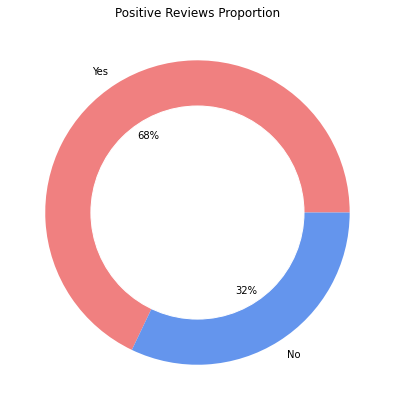

In [15]:
# Grafico a torta della distribuzione della variabile target

Y_count = len(df[df['pos_review'] == 1])
N_count = len(df[df['pos_review'] == 0])

# create data
names='Yes', 'No',
size=[Y_count,N_count]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.figure(figsize=(7,7))
plt.pie(size, labels=names, colors=['lightcoral','cornflowerblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Positive Reviews Proportion")

plt.show()

# Preparazione delle variabili testuali

###Tokenization, stopwords and punctuation removal

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
stopword_list = stopwords.words('english')

new_observations = []
for text in df['body']:
  # convert into lower case text
  text = text.lower()
  #tokenization and stopwords removal
  tokens = [token for token in word_tokenize(text) if token not in stopword_list]
  #removing punctuation
  tokens = [token for token in tokens if token.isalnum()]

  new_observations.append(tokens)

df['body_tok'] = new_observations

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df.head(2)

,review_rating,date,year,review_title,body,product_title,product_rating,language,english,pos_review,body_tok
1,1,"December 20, 2016",2016,Phones locked,1 star because the phones locked so I have to ...,Motorola I265 phone,3.0,en,1,0,"[1, star, phones, locked, pay, additional, fee..."
2,5,"December 13, 2009",2009,Excellent product,The product has been very good. I had used thi...,Motorola I265 phone,3.0,en,1,1,"[product, good, used, cell, phone, one, projec..."


In [18]:
# Esempio di body_tok

list(df['body_tok'])[0]

['1', 'star', 'phones', 'locked', 'pay', 'additional', 'fees', 'unlock']

### Create bigrams and trigrams

In [19]:
new_observations = list(df['body_tok'])

for id, tokens in enumerate(df['body_tok']):
  bigram_list = ['B_' + p1 + '_' + p2 for p1, p2 in bigrams(tokens)]
  trigrams_list = ['T_' + p1 + '_' + p2 + '_' + p3 for p1, p2, p3 in trigrams(tokens)]

  new_ngrams = []
  new_ngrams.extend(bigram_list)
  new_ngrams.extend(trigrams_list)
  new_observations[id].append(new_ngrams)

df['body_tok_ngrams'] = new_observations

In [20]:
# Esempio di 'body_tok_ngrams'

list(df['body_tok_ngrams'])[0]

['1',
 'star',
 'phones',
 'locked',
 'pay',
 'additional',
 'fees',
 'unlock',
 ['B_1_star',
  'B_star_phones',
  'B_phones_locked',
  'B_locked_pay',
  'B_pay_additional',
  'B_additional_fees',
  'B_fees_unlock',
  'T_1_star_phones',
  'T_star_phones_locked',
  'T_phones_locked_pay',
  'T_locked_pay_additional',
  'T_pay_additional_fees',
  'T_additional_fees_unlock']]

In [21]:
# Most frequent trigrams, senza pulizia

sum_of_reviews = [] # metto insieme tutte le recensioni
frequent_trigrams = []

for e in df['body']:
    sum_of_reviews.append(e)

sum_of_reviews = str(sum_of_reviews) #trasformo in stringa, come se fosse un unico testo

ngram_counts = Counter(ngrams(sum_of_reviews.split(), 3))
y = ngram_counts.most_common(20)
frequent_trigrams.append(y)

# Visualizzo trigrammi più frequenti
frequent_trigrams

[[(('the', 'phone', 'is'), 1367),
  (('this', 'phone', 'is'), 1245),
  (('this', 'phone', 'for'), 1109),
  (('I', 'had', 'to'), 1032),
  (('a', 'lot', 'of'), 1030),
  (('battery', 'life', 'is'), 864),
  (('I', 'have', 'to'), 855),
  (('phone', 'for', 'the'), 844),
  (('the', 'phone', 'and'), 806),
  (('of', 'the', 'phone'), 750),
  (('is', 'a', 'great'), 713),
  (('the', 'phone', 'was'), 710),
  (('bought', 'this', 'phone'), 687),
  (('this', 'phone', 'and'), 663),
  (('this', 'is', 'a'), 659),
  (('the', 'battery', 'life'), 623),
  (('and', 'the', 'phone'), 612),
  (('on', 'the', 'phone'), 601),
  (('it', 'was', 'a'), 584),
  (('it', 'is', 'a'), 584)]]

In [22]:
# Trigrammi più frequenti da testo pulito ('body_tok')

sum_of_reviews = [] # metto insieme tutte le recensioni
frequent_trigrams = []

for e in df['body_tok']:
    sum_of_reviews.append(e)

sum_of_reviews = str(sum_of_reviews) #trasformo in stringa, come se fosse un unico testo

ngram_counts = Counter(ngrams(sum_of_reviews.split(), 3))
y = ngram_counts.most_common(20)
frequent_trigrams.append(y)

# Visualizzo trigrammi più frequenti
frequent_trigrams

[[(("['great',", "'phone',", "['B_great_phone']],"), 406),
  (("'phone',", "'works',", "'great',"), 331),
  (("'great',", "'battery',", "'life',"), 315),
  (("'brand',", "'new',", "'phone',"), 270),
  (("'like',", "'brand',", "'new',"), 264),
  (("'looks',", "'brand',", "'new',"), 262),
  (("'battery',", "'life',", "'great',"), 246),
  (("'good',", "'battery',", "'life',"), 237),
  (("'battery',", "'life',", "'good',"), 224),
  (("'phone',", "'great',", "'price',"), 222),
  (("['love',", "'phone',", "['B_love_phone']],"), 208),
  (("'best',", "'phone',", "'ever',"), 198),
  (("'phone',", "'ever',", "'owned',"), 197),
  (("['best',", "'phone',", "'ever',"), 193),
  (("'phone',", "'battery',", "'life',"), 186),
  (("['great',", "'phone',", "'price',"), 167),
  (("'micro',", "'sd',", "'card',"), 161),
  (("'looked',", "'brand',", "'new',"), 160),
  (("['great',", "'phone',", "'great',"), 160),
  (("'new',", "'sim',", "'card',"), 159)]]

### Create bigrams and trigrams with lemmatizations

In [23]:
new_observations = []

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
wnl = WordNetLemmatizer()
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV

for id, text in enumerate(df['body']):
  
  text = text.lower()
  tokens = [token for token in word_tokenize(text) if token not in stopword_list]
  tokens = [token for token in tokens if token.isalnum()]

  lemmas = []
  for token, tag in pos_tag(tokens):
    
    lemmas.append('LEM_'+wnl.lemmatize(token, tag_map[tag[0]]))
  
  bigrams_list = ['B_' + p1 + '_' + p2 for p1, p2 in bigrams(lemmas)]
  trigrams_list = ['T_' + p1 + '_' + p2 + '_' + p3 for p1, p2, p3 in trigrams(lemmas)]

  new_ngrams = []
  new_ngrams.extend(lemmas)
  new_ngrams.extend(bigrams_list)
  new_ngrams.extend(trigrams_list)
  new_observations.append(new_ngrams)

df['body_lem_ngrams'] = new_observations

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [24]:
# Esempio di 'body_lem_ngrams'

list(df['body_lem_ngrams'])[0]

['LEM_1',
 'LEM_star',
 'LEM_phone',
 'LEM_lock',
 'LEM_pay',
 'LEM_additional',
 'LEM_fee',
 'LEM_unlock',
 'B_LEM_1_LEM_star',
 'B_LEM_star_LEM_phone',
 'B_LEM_phone_LEM_lock',
 'B_LEM_lock_LEM_pay',
 'B_LEM_pay_LEM_additional',
 'B_LEM_additional_LEM_fee',
 'B_LEM_fee_LEM_unlock',
 'T_LEM_1_LEM_star_LEM_phone',
 'T_LEM_star_LEM_phone_LEM_lock',
 'T_LEM_phone_LEM_lock_LEM_pay',
 'T_LEM_lock_LEM_pay_LEM_additional',
 'T_LEM_pay_LEM_additional_LEM_fee',
 'T_LEM_additional_LEM_fee_LEM_unlock']

## Divisione dataset per content drift

In [25]:
df = df.sort_values(by='year', ascending=False) # Ordine decrescente

test_set = df[0:20000]
training_set_2 = df[20000:30000]
training_set_1 = df[30000:40000]
remaining_set = df[40000:]

In [26]:
# Test set solo 2019
print('Test')
print(test_set['year'].head(1))
print(test_set['year'].tail(1))
print()

# Train 2
print('Train 2')
print(training_set_2['year'].head(1))
print(training_set_2['year'].tail(1))
print()

# Train 1
print('Train 1')
print(training_set_1['year'].head(1))
print(training_set_1['year'].tail(1))
print()

# Remaining set
print('Remaining set')
print(remaining_set['year'].head(1))
print(remaining_set['year'].tail(1))
print()

Test
61224    2019
Name: year, dtype: int64
50117    2019
Name: year, dtype: int64

Train 2
50118    2019
Name: year, dtype: int64
27930    2018
Name: year, dtype: int64

Train 1
27931    2018
Name: year, dtype: int64
31163    2017
Name: year, dtype: int64

Remaining set
31164    2017
Name: year, dtype: int64
36    2009
Name: year, dtype: int64



In [27]:
print(len(test_set))
print(len(training_set_1))
print(len(training_set_2))
print(len(remaining_set))

20000
10000
10000
13337


In [28]:
# Test set
test_set['year'].value_counts()

2019    20000
Name: year, dtype: int64

In [29]:
# Train 2
training_set_2['year'].value_counts()

2018    6762
2019    3238
Name: year, dtype: int64

In [30]:
# Train 1
training_set_1['year'].value_counts()

2017    5575
2018    4425
Name: year, dtype: int64

In [31]:
# Remaining set
remaining_set['year'].value_counts()

2016    4336
2015    3490
2014    2485
2013    1594
2017    1075
2012     289
2011      50
2010      12
2009       6
Name: year, dtype: int64

In [32]:
test_set['year'].unique()

array([2019])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

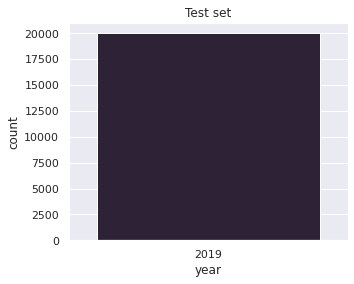

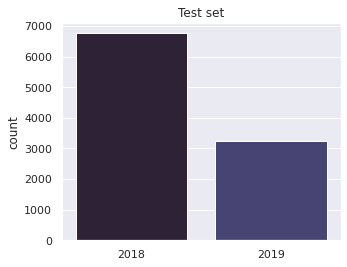

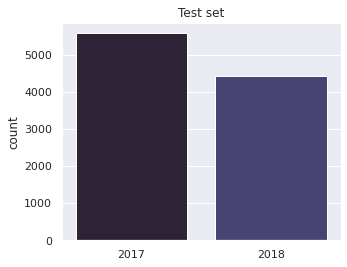

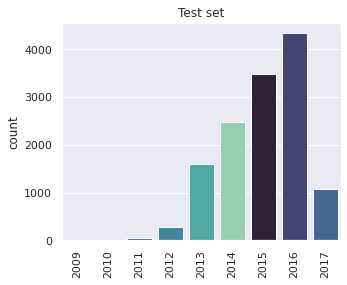

In [33]:
pal = sns.color_palette("mako")

# Test set
plt.figure(figsize=(5, 4))
sns.set(style=('darkgrid'))
#plt.xticks(rotation=90) # etichette asse x in verticale
plt.xticks(ticks=test_set['year'].unique()) # etichette asse x in verticale
g = sns.countplot(test_set['year'], palette=pal).set_title('Test set')
#(test_set['year'], bins=len(test_set['year'].unique())).set_title('Test set')
#g = sns.histplot(test_set['year'], bins=len(test_set['year'].unique())).set_title('Test set')

# Training set 2
plt.figure(figsize=(5, 4))
sns.set(style=('darkgrid'))
plt.xticks(ticks=training_set_2['year'].unique())
#plt.xticks(rotation=90) # etichette asse x in verticale
g = sns.countplot(sorted(training_set_2['year'], reverse=True), palette=pal).set_title('Test set')

# Training set 1
plt.figure(figsize=(5, 4))
sns.set(style=('darkgrid'))
plt.xticks(ticks=training_set_1['year'].unique())
g = sns.countplot(sorted(training_set_1['year'], reverse=True), palette=pal).set_title('Test set')

# Remaining set
plt.figure(figsize=(5, 4))
sns.set(style=('darkgrid'))
plt.xticks(rotation=90) # etichette asse x in verticale
plt.xticks(ticks=remaining_set['year'].unique())
g = sns.countplot(sorted(remaining_set['year'], reverse=True), palette=pal).set_title('Test set')

Salvo i dataset creati

In [34]:
from google.colab import files

training_set_1.to_csv('drive/MyDrive/TextAnalytics/training_set_1.csv')
training_set_2.to_csv('drive/MyDrive/TextAnalytics/training_set_2.csv')
test_set.to_csv('drive/MyDrive/TextAnalytics/test_set.csv')
remaining_set.to_csv('drive/MyDrive/TextAnalytics/remaining_set.csv')